Logistic Regression Report:
              precision    recall  f1-score   support

      common       0.58      0.46      0.51       250
     serious       0.65      0.75      0.70       337

    accuracy                           0.63       587
   macro avg       0.61      0.61      0.61       587
weighted avg       0.62      0.63      0.62       587

Accuracy: 0.626916524701874
AUC-ROC: 0.6816676557863501


Random Forest Report:
              precision    recall  f1-score   support

      common       0.66      0.58      0.62       250
     serious       0.72      0.78      0.75       337

    accuracy                           0.70       587
   macro avg       0.69      0.68      0.68       587
weighted avg       0.69      0.70      0.69       587

Accuracy: 0.696763202725724
AUC-ROC: 0.6816676557863501


SVM Report:
              precision    recall  f1-score   support

      common       0.67      0.53      0.59       250
     serious       0.70      0.81      0.75       337

    

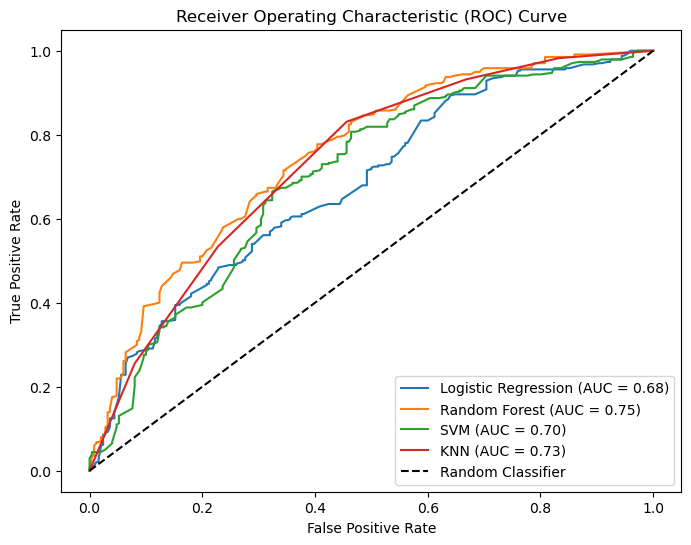

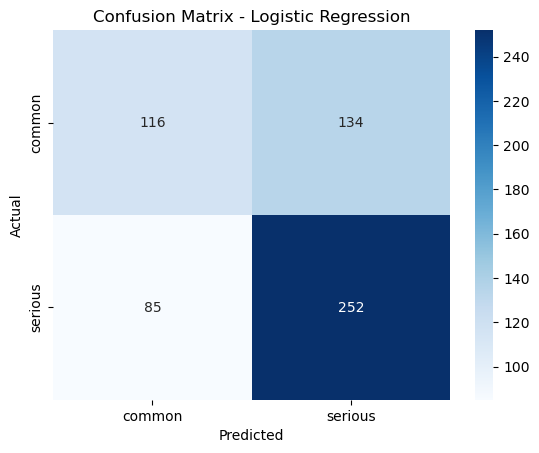

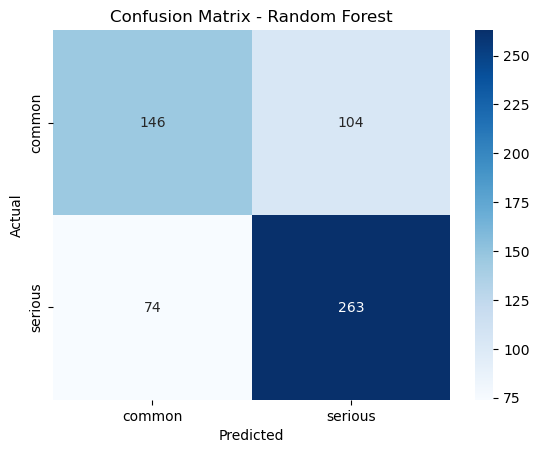

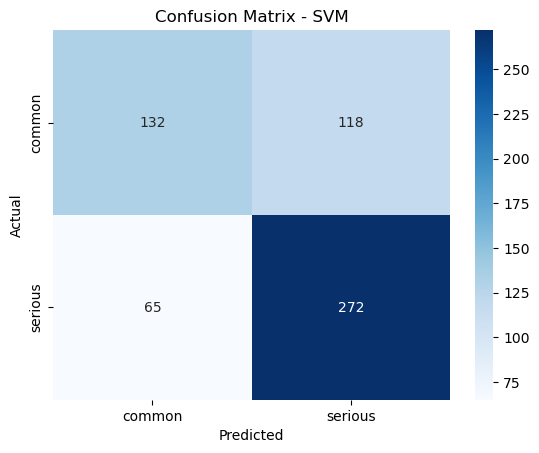

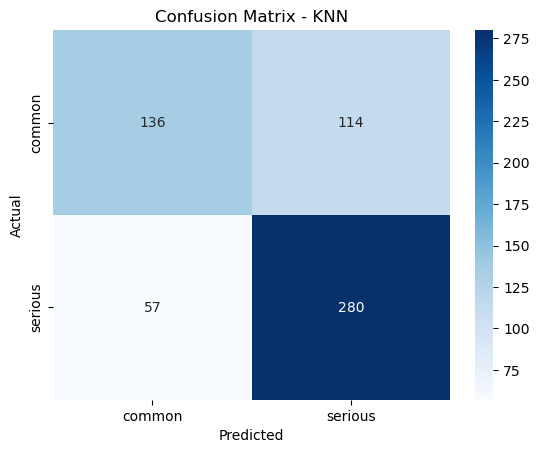

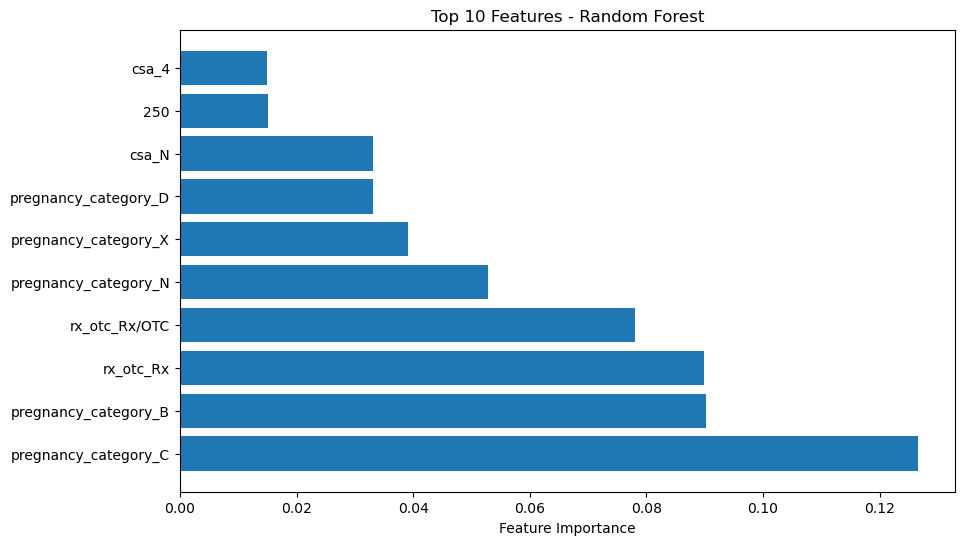

In [15]:
# Step 1: Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load Data
data = pd.read_csv('drugs_side_effects_drugs_com.csv/drugs_side_effects_drugs_com.csv')

# Step 3: Data Preprocessing
data['side_effects'] = data['side_effects'].fillna('unknown')
data['medical_condition_description'] = data['medical_condition_description'].fillna('')
data['side_effects_binary'] = data['side_effects'].apply(lambda x: 'serious' if 'severe' in x.lower() else 'common')

# Step 4: Feature Encoding
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(data['medical_condition_description']).toarray()
categorical_features = pd.get_dummies(data[['rx_otc', 'pregnancy_category', 'csa']], drop_first=True)
X = pd.concat([pd.DataFrame(X_text), categorical_features.reset_index(drop=True)], axis=1)
X.columns = X.columns.astype(str)
y = data['side_effects_binary']

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Build Models
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

# Step 7: Evaluate Models
def evaluate_model(y_test, y_pred, model_name):
    print(f"{model_name} Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"AUC-ROC: {roc_auc_score(pd.get_dummies(y_test)['serious'], log_reg.predict_proba(X_test)[:, 1])}")
    print("\n")

evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_svm, "SVM")
evaluate_model(y_test, y_pred_knn, "KNN")

# Step 8: ROC Curve Plotting

def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Compute ROC for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(pd.get_dummies(y_test)['serious'], log_reg.predict_proba(X_test)[:, 1])
roc_auc_log = roc_auc_score(pd.get_dummies(y_test)['serious'], log_reg.predict_proba(X_test)[:, 1])

# Compute ROC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(pd.get_dummies(y_test)['serious'], rf_clf.predict_proba(X_test)[:, 1])
roc_auc_rf = roc_auc_score(pd.get_dummies(y_test)['serious'], rf_clf.predict_proba(X_test)[:, 1])

# Compute ROC for SVM
fpr_svm, tpr_svm, _ = roc_curve(pd.get_dummies(y_test)['serious'], svm_clf.predict_proba(X_test)[:, 1])
roc_auc_svm = roc_auc_score(pd.get_dummies(y_test)['serious'], svm_clf.predict_proba(X_test)[:, 1])

# Compute ROC for KNN
fpr_knn, tpr_knn, _ = roc_curve(pd.get_dummies(y_test)['serious'], knn_clf.predict_proba(X_test)[:, 1])
roc_auc_knn = roc_auc_score(pd.get_dummies(y_test)['serious'], knn_clf.predict_proba(X_test)[:, 1])

# Plot ROC curves for all models
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_log, tpr_log, roc_auc_log, "Logistic Regression")
plot_roc_curve(fpr_rf, tpr_rf, roc_auc_rf, "Random Forest")
plot_roc_curve(fpr_svm, tpr_svm, roc_auc_svm, "SVM")
plot_roc_curve(fpr_knn, tpr_knn, roc_auc_knn, "KNN")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Step 9: Confusion Matrix Plotting
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred, labels=['common', 'serious'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['common', 'serious'], yticklabels=['common', 'serious'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot Confusion Matrices for all models
plot_confusion_matrix(y_test, y_pred_log, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_confusion_matrix(y_test, y_pred_knn, "KNN")

# Step 10: Feature Importance (for Random Forest)
def plot_feature_importance(model, model_name):
    importances = model.feature_importances_
    indices = importances.argsort()[-10:][::-1]  # Get the top 10 features
    plt.figure(figsize=(10, 6))
    plt.title(f"Top 10 Features - {model_name}")
    plt.barh(range(10), importances[indices], align="center")
    plt.yticks(range(10), [X.columns[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.show()

# Plot Feature Importance for Random Forest
plot_feature_importance(rf_clf, "Random Forest")

